# SmallBizPulse: Exploratory Data Analysis
## An Early Warning & Intervention System for Restaurant Survival

**Team ID:** AP (Armadillo Pulse) — Team #7

**Team Members:** Lafi Alanazi, Afan Jeelani, Chandra Carr, Joshua Dollison, Sonia Parikh

**Course:** CIS 509 — Analytics Unstructured Data

**Date:** 22nd February 2026

## Environment Setup & Data Loading

Upload the Yelp Academic Dataset JSON files

In [ ]:
# ============================================================
# SETUP: Mount Drive, Install Dependencies, Configure Styling
# ============================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install VADER for sentiment analysis
!pip install vaderSentiment -q

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from collections import Counter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ── Consistent Plot Styling ──────────────────────────────────
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
})

# SmallBizPulse color palette
COLORS = {
    'primary': '#2563EB',
    'secondary': '#F59E0B',
    'open': '#10B981',
    'closed': '#EF4444',
    'accent1': '#8B5CF6',
    'accent2': '#EC4899',
    'neutral': '#6B7280',
    'bg': '#F9FAFB',
}
PALETTE_OC = [COLORS['open'], COLORS['closed']]

print("Setup complete — libraries loaded, styling configured.")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00
Setup complete — libraries loaded, styling configured.


In [ ]:
# ============================================================
# DATA LOADING
# ============================================================
# >>> UPDATE THIS PATH to match your Google Drive folder <<<
DATA_PATH = '/content/drive/MyDrive/CIS 509/yelp_dataset_new/'

def load_json(filename):
    filepath = DATA_PATH + filename
    with open(filepath, 'r') as f:
        first_char = f.read(1)
        f.seek(0)
        if first_char == '[':
            return pd.DataFrame(json.load(f))
        else:
            return pd.read_json(f, lines=True)

print("Loading datasets...")
business_df = load_json('yelp_academic_dataset_business.json')
print(f"  Business: {len(business_df):,} records")

review_df = load_json('yelp_academic_dataset_review.json')
print(f"  Review:   {len(review_df):,} records")

tip_df = load_json('yelp_academic_dataset_tip.json')
print(f"  Tip:      {len(tip_df):,} records")

checkin_df = load_json('yelp_academic_dataset_checkin.json')
print(f"  Checkin:  {len(checkin_df):,} records")

user_df = load_json('yelp_academic_dataset_user.json')
print(f"  User:     {len(user_df):,} records")

print("\nAll datasets loaded successfully.")

Loading datasets...
  Business: 9,973 records
  Review:   100,000 records
  Tip:      264,693 records
  Checkin:  9,337 records
  User:     79,345 records

All datasets loaded successfully.


## Section 3: Executive Summary

**SmallBizPulse** is an analytics-driven early warning system that predicts restaurant survival and provides actionable intervention recommendations for local economic development agencies, chambers of commerce, and community organizations.

**Core Hypothesis:** Online reviews contain early warning signals, declining sentiment, recurring complaints about service or food quality, and shifts in customer engagement that precede restaurant closure by months or even years. By detecting these signals early, stakeholders can intervene before closure becomes inevitable.

**Our Approach:**

1. **Survival Prediction** — Track sentiment and rating trajectories over time to estimate closure risk
2. **Diagnostic Topic Modeling** — Use BERTopic on negative reviews to surface the specific issues driving decline (e.g., slow service, food quality, management problems)
3. **Intervention Recommendations** — Map discovered topics to targeted, actionable interventions
4. **Resilience Analysis** — Compare what separates survivors from closures, with attention to vulnerable segments

**Key Dataset Advantage:** The Yelp Academic Dataset contains 4,133 restaurants with a 37.7% closure rate (1,557 closed), providing rich labeled outcome data for supervised learning. This EDA validates our hypothesis and establishes the foundation for modeling.

## Section 4: Data Sources & Filtering Criteria

In [ ]:
# ============================================================
# DATA SOURCES & FILTERING CRITERIA
# ============================================================

# Step 1: Filter for restaurants
# A business is classified as a "restaurant" if its Yelp categories
# contain the word "Restaurants" (case-insensitive).
restaurant_df = business_df[
    business_df['categories'].str.contains('Restaurants', case=False, na=False)
].copy()

# Step 2: Get restaurant business IDs
restaurant_ids = set(restaurant_df['business_id'])

# Step 3: Filter reviews to restaurant-only
rest_review_df = review_df[review_df['business_id'].isin(restaurant_ids)].copy()
rest_review_df['date'] = pd.to_datetime(rest_review_df['date'])
rest_review_df['year'] = rest_review_df['date'].dt.year

# Step 4: Filter tips to restaurant-only
rest_tip_df = tip_df[tip_df['business_id'].isin(restaurant_ids)].copy()

# Step 5: Filter checkins to restaurant-only
rest_checkin_df = checkin_df[checkin_df['business_id'].isin(restaurant_ids)].copy()

# Step 6: Merge business status onto reviews
status_map = restaurant_df.set_index('business_id')['is_open'].to_dict()
rest_review_df['is_open'] = rest_review_df['business_id'].map(status_map)
rest_review_df['status'] = rest_review_df['is_open'].map({1: 'Open', 0: 'Closed'})

# ── Print Summary ────────────────────────────────────────────
print("=" * 65)
print("DATA SOURCES & FILTERING SUMMARY")
print("=" * 65)

print("\nPRIMARY DATA SOURCE: Yelp Academic Dataset")
print("-" * 45)

print("\nFull Dataset:")
print(f"  Businesses:  {len(business_df):>8,}")
print(f"  Reviews:     {len(review_df):>8,}")
print(f"  Tips:        {len(tip_df):>8,}")
print(f"  Check-ins:   {len(checkin_df):>8,}")
print(f"  Users:       {len(user_df):>8,}")

print("\nFiltered to Restaurants (categories contain 'Restaurants'):")
print(f"  Restaurants:        {len(restaurant_df):>8,}")
print(f"  Restaurant Reviews: {len(rest_review_df):>8,}")
print(f"  Restaurant Tips:    {len(rest_tip_df):>8,}")
print(f"  Restaurant Checkins:{len(rest_checkin_df):>8,}")

n_open = (restaurant_df['is_open'] == 1).sum()
n_closed = (restaurant_df['is_open'] == 0).sum()
print("\nRestaurant Status:")
print(f"  Open:   {n_open:>5,}  ({n_open / len(restaurant_df) * 100:.1f}%)")
print(f"  Closed: {n_closed:>5,}  ({n_closed / len(restaurant_df) * 100:.1f}%)")

print(f"\nDate Range: {rest_review_df['date'].min().strftime('%Y-%m-%d')} to "
      f"{rest_review_df['date'].max().strftime('%Y-%m-%d')}")

print("\nFILTERING CRITERIA APPLIED:")
print("  1. Category filter: categories.str.contains('Restaurants')")
print("  2. Reviews, tips, and check-ins filtered by restaurant business_id")
print("  3. No minimum review count threshold (preserving data-sparse")
print("     businesses is important for studying closure patterns)")
print("  4. No date range restriction (full temporal span needed for time-series)")

DATA SOURCES & FILTERING SUMMARY

PRIMARY DATA SOURCE: Yelp Academic Dataset
---------------------------------------------

Full Dataset:
  Businesses:     9,973
  Reviews:      100,000
  Tips:         264,693
  Check-ins:      9,337
  Users:         79,345

Filtered to Restaurants (categories contain 'Restaurants'):
  Restaurants:           4,132
  Restaurant Reviews:   72,124
  Restaurant Tips:      20,394
  Restaurant Checkins:   4,085

Restaurant Status:
  Open:   2,575  (62.3%)
  Closed: 1,557  (37.7%)

Date Range: 2005-03-01 to 2018-10-04

FILTERING CRITERIA APPLIED:
  1. Category filter: categories.str.contains('Restaurants')
  2. Reviews, tips, and check-ins filtered by restaurant business_id
  3. No minimum review count threshold (preserving data-sparse
     businesses is important for studying closure patterns)
  4. No date range restriction (full temporal span needed for time-series)


---

## Section 5: Summary Statistics

In [ ]:
# ============================================================
# 5a: CORE TEXT STATISTICS
# ============================================================

# Tokenize reviews (whitespace split for token counts)
rest_review_df['word_count'] = rest_review_df['text'].str.split().str.len()
rest_review_df['char_count'] = rest_review_df['text'].str.len()

# Vocabulary analysis
all_words = ' '.join(rest_review_df['text'].dropna()).lower().split()
unique_words = set(all_words)

print("=" * 65)
print("CORE TEXT STATISTICS — Restaurant Reviews")
print("=" * 65)
print(f"  a. Number of reviews:           {len(rest_review_df):>10,}")
print(f"  b. Total number of tokens:      {len(all_words):>10,}")
print(f"  c. Unique words (vocabulary):   {len(unique_words):>10,}")
print(f"  d. Avg review length (words):   {rest_review_df['word_count'].mean():>10.1f}")
print(f"     Median review length (words):{rest_review_df['word_count'].median():>10.0f}")
print(f"  e. Unique customers (reviewers):{rest_review_df['user_id'].nunique():>10,}")
print(f"  f. Unique restaurants:          {rest_review_df['business_id'].nunique():>10,}")
print()
print("  Additional:")
print(f"  Avg review length (chars):      {rest_review_df['char_count'].mean():>10.1f}")
print(f"  Avg stars per review:           {rest_review_df['stars'].mean():>10.2f}")
print(f"  Avg reviews per restaurant:     {len(rest_review_df) / rest_review_df['business_id'].nunique():>10.1f}")

CORE TEXT STATISTICS — Restaurant Reviews
  a. Number of reviews:               72,124
  b. Total number of tokens:       7,128,068
  c. Unique words (vocabulary):      163,953
  d. Avg review length (words):         98.8
     Median review length (words):        70
  e. Unique customers (reviewers):    59,366
  f. Unique restaurants:               4,132

  Additional:
  Avg review length (chars):           537.3
  Avg stars per review:                 3.81
  Avg reviews per restaurant:           17.5


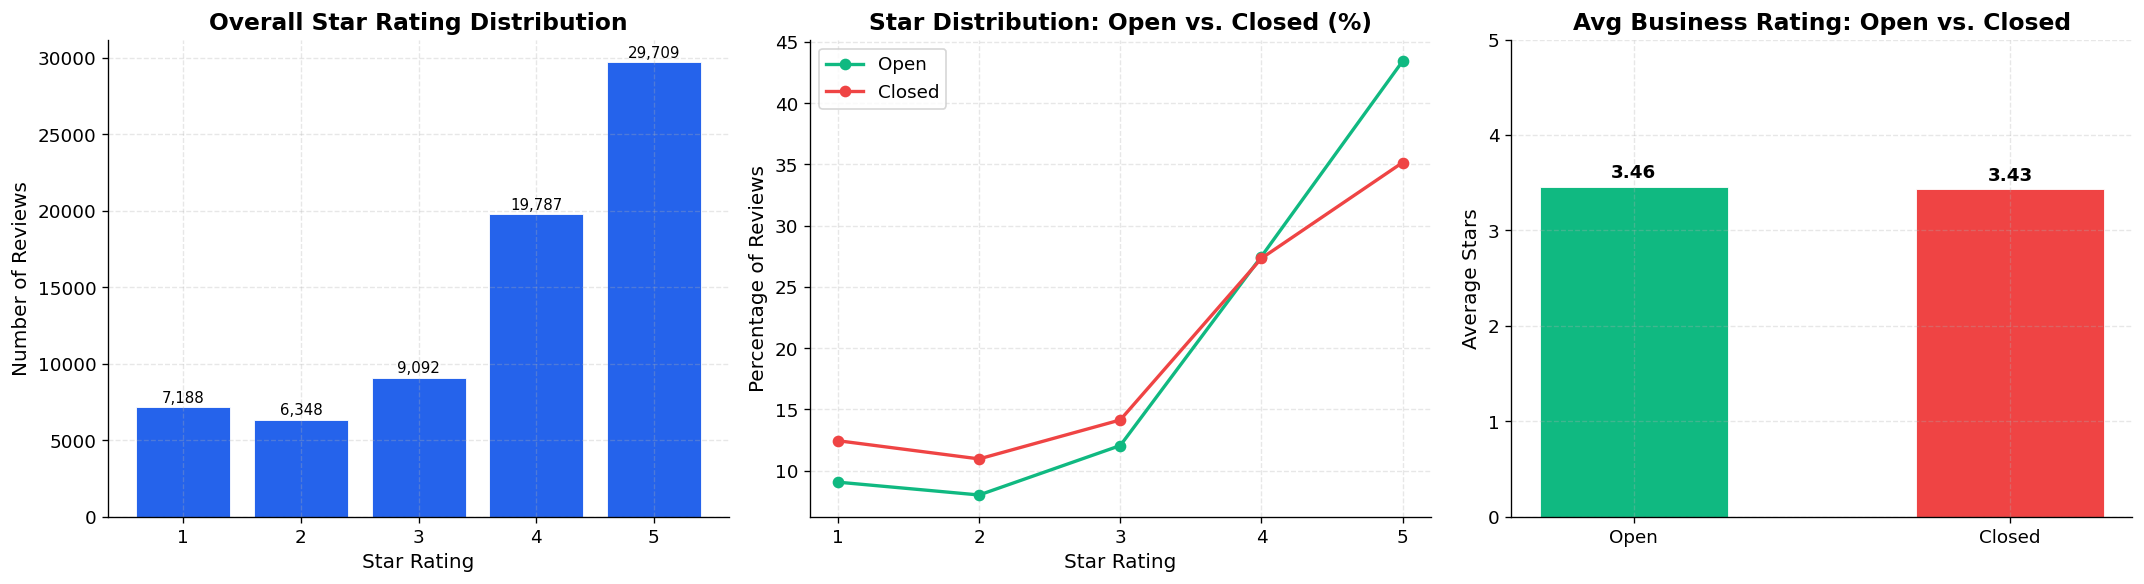


Key Finding: Closed restaurants avg rating = 3.43 vs. 3.46 for open (difference = 0.03 stars).


In [ ]:
# ============================================================
# 5b: STAR RATING DISTRIBUTION — Open vs. Closed
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overall star distribution
star_counts = rest_review_df['stars'].value_counts().sort_index()
axes[0].bar(star_counts.index, star_counts.values, color=COLORS['primary'],
            edgecolor='white', linewidth=0.5)
axes[0].set_title('Overall Star Rating Distribution')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_xticks([1, 2, 3, 4, 5])
for x, y in zip(star_counts.index, star_counts.values):
    axes[0].text(x, y + 100, f'{y:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Star distribution by status (normalized)
for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    subset = rest_review_df[rest_review_df['status'] == status]
    star_pct = subset['stars'].value_counts(normalize=True).sort_index() * 100
    axes[1].plot(star_pct.index, star_pct.values, 'o-', color=color,
                 label=status, linewidth=2, markersize=6)
axes[1].set_title('Star Distribution: Open vs. Closed (%)')
axes[1].set_xlabel('Star Rating')
axes[1].set_ylabel('Percentage of Reviews')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].legend()

# Plot 3: Average business rating by status
avg_stars_open = restaurant_df[restaurant_df['is_open'] == 1]['stars'].mean()
avg_stars_closed = restaurant_df[restaurant_df['is_open'] == 0]['stars'].mean()
bars = axes[2].bar(['Open', 'Closed'], [avg_stars_open, avg_stars_closed],
                    color=PALETTE_OC, edgecolor='white', linewidth=0.5, width=0.5)
axes[2].set_title('Avg Business Rating: Open vs. Closed')
axes[2].set_ylabel('Average Stars')
axes[2].set_ylim(0, 5)
for bar, val in zip(bars, [avg_stars_open, avg_stars_closed]):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.05,
                 f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nKey Finding: Closed restaurants avg rating = {avg_stars_closed:.2f} vs. "
      f"{avg_stars_open:.2f} for open (difference = {avg_stars_open - avg_stars_closed:.2f} stars).")

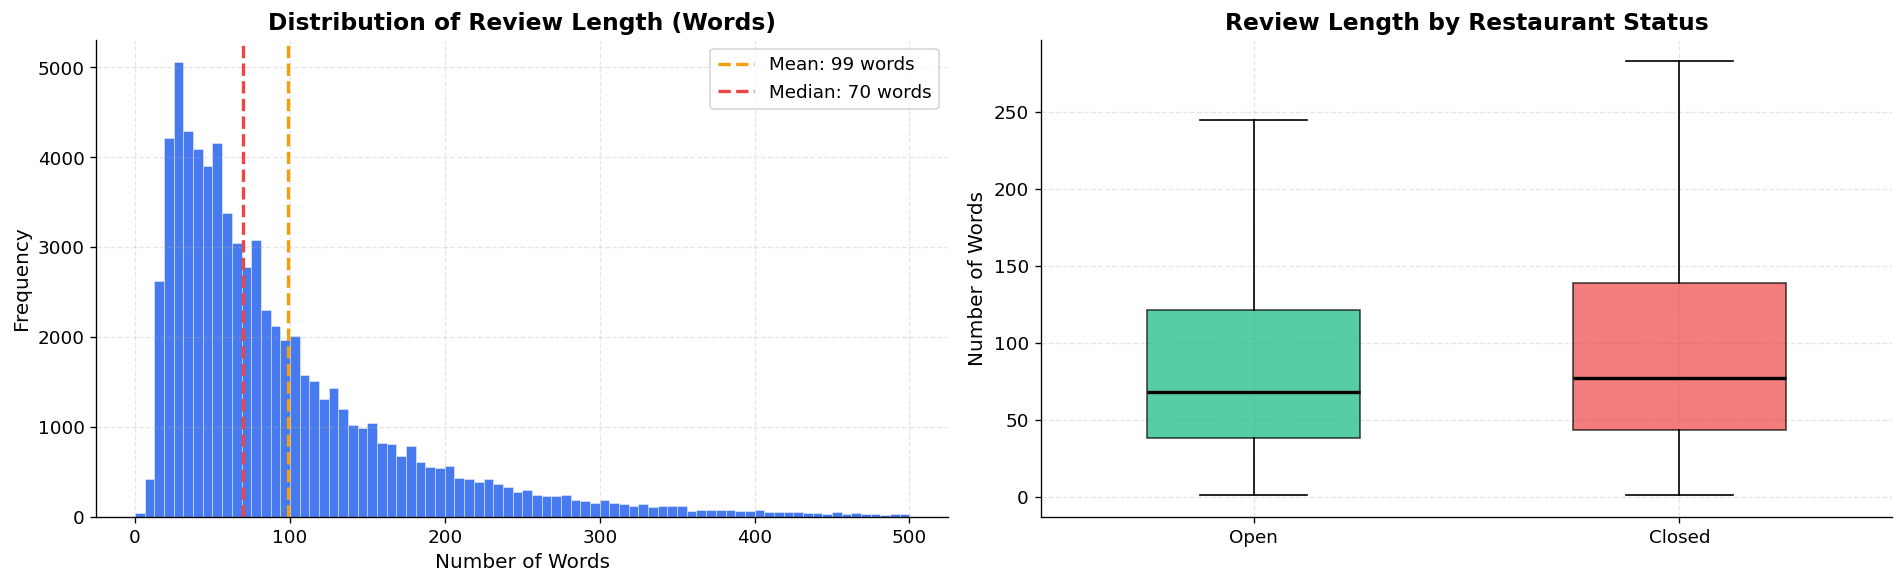


Review Length Stats:
  Open restaurants:   mean = 95.3 words, median = 68
  Closed restaurants: mean = 108.4 words, median = 77


In [ ]:
# ============================================================
# 5c: REVIEW LENGTH DISTRIBUTION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Overall review length distribution
axes[0].hist(rest_review_df['word_count'], bins=80, color=COLORS['primary'],
             edgecolor='white', linewidth=0.3, alpha=0.85, range=(0, 500))
axes[0].axvline(rest_review_df['word_count'].mean(), color=COLORS['secondary'],
                linestyle='--', linewidth=2,
                label=f"Mean: {rest_review_df['word_count'].mean():.0f} words")
axes[0].axvline(rest_review_df['word_count'].median(), color=COLORS['closed'],
                linestyle='--', linewidth=2,
                label=f"Median: {rest_review_df['word_count'].median():.0f} words")
axes[0].set_title('Distribution of Review Length (Words)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot 2: Review length by status (box plot)
data_open = rest_review_df[rest_review_df['status'] == 'Open']['word_count']
data_closed = rest_review_df[rest_review_df['status'] == 'Closed']['word_count']

bp = axes[1].boxplot([data_open, data_closed], labels=['Open', 'Closed'],
                      patch_artist=True, showfliers=False, widths=0.5,
                      medianprops=dict(color='black', linewidth=2))
bp['boxes'][0].set_facecolor(COLORS['open'])
bp['boxes'][1].set_facecolor(COLORS['closed'])
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_alpha(0.7)
axes[1].set_title('Review Length by Restaurant Status')
axes[1].set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

print(f"\nReview Length Stats:")
print(f"  Open restaurants:   mean = {data_open.mean():.1f} words, median = {data_open.median():.0f}")
print(f"  Closed restaurants: mean = {data_closed.mean():.1f} words, median = {data_closed.median():.0f}")

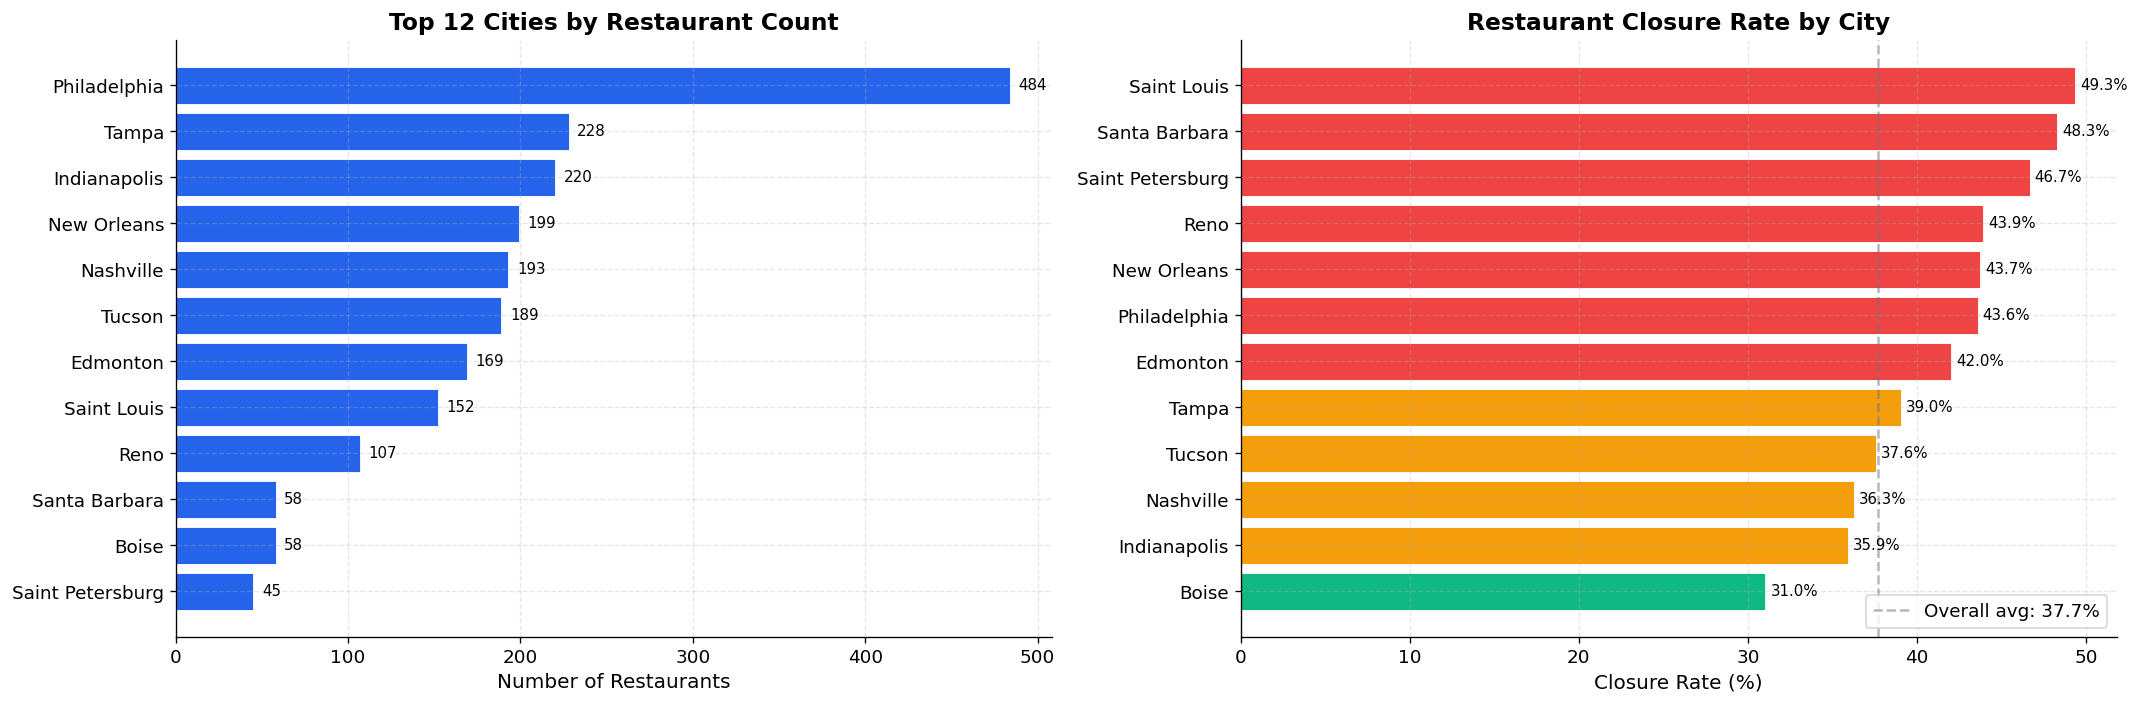

In [ ]:
# ============================================================
# 5d: GEOGRAPHIC DISTRIBUTION
# ============================================================

rest_cities = restaurant_df['city'].value_counts().head(12)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top cities by restaurant count
bars = axes[0].barh(rest_cities.index[::-1], rest_cities.values[::-1],
                     color=COLORS['primary'], edgecolor='white', linewidth=0.5)
axes[0].set_title('Top 12 Cities by Restaurant Count')
axes[0].set_xlabel('Number of Restaurants')
for bar in bars:
    width = bar.get_width()
    axes[0].text(width + 5, bar.get_y() + bar.get_height()/2,
                 f'{int(width):,}', ha='left', va='center', fontsize=9)

# Plot 2: Closure rate by top cities
city_stats = []
for city in rest_cities.index[:12]:
    city_data = restaurant_df[restaurant_df['city'] == city]
    total = len(city_data)
    closed = (city_data['is_open'] == 0).sum()
    city_stats.append({'city': city, 'total': total, 'closed': closed,
                       'closure_rate': closed / total * 100})
city_stats_df = pd.DataFrame(city_stats).sort_values('closure_rate', ascending=True)

bar_colors = [COLORS['closed'] if r > 40 else COLORS['secondary'] if r > 35
              else COLORS['open'] for r in city_stats_df['closure_rate']]
bars2 = axes[1].barh(city_stats_df['city'], city_stats_df['closure_rate'],
                      color=bar_colors, edgecolor='white', linewidth=0.5)
axes[1].set_title('Restaurant Closure Rate by City')
axes[1].set_xlabel('Closure Rate (%)')
axes[1].axvline(37.7, color=COLORS['neutral'], linestyle='--', alpha=0.5,
                label='Overall avg: 37.7%')
axes[1].legend(loc='lower right')
for bar, rate in zip(bars2, city_stats_df['closure_rate']):
    axes[1].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                 f'{rate:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

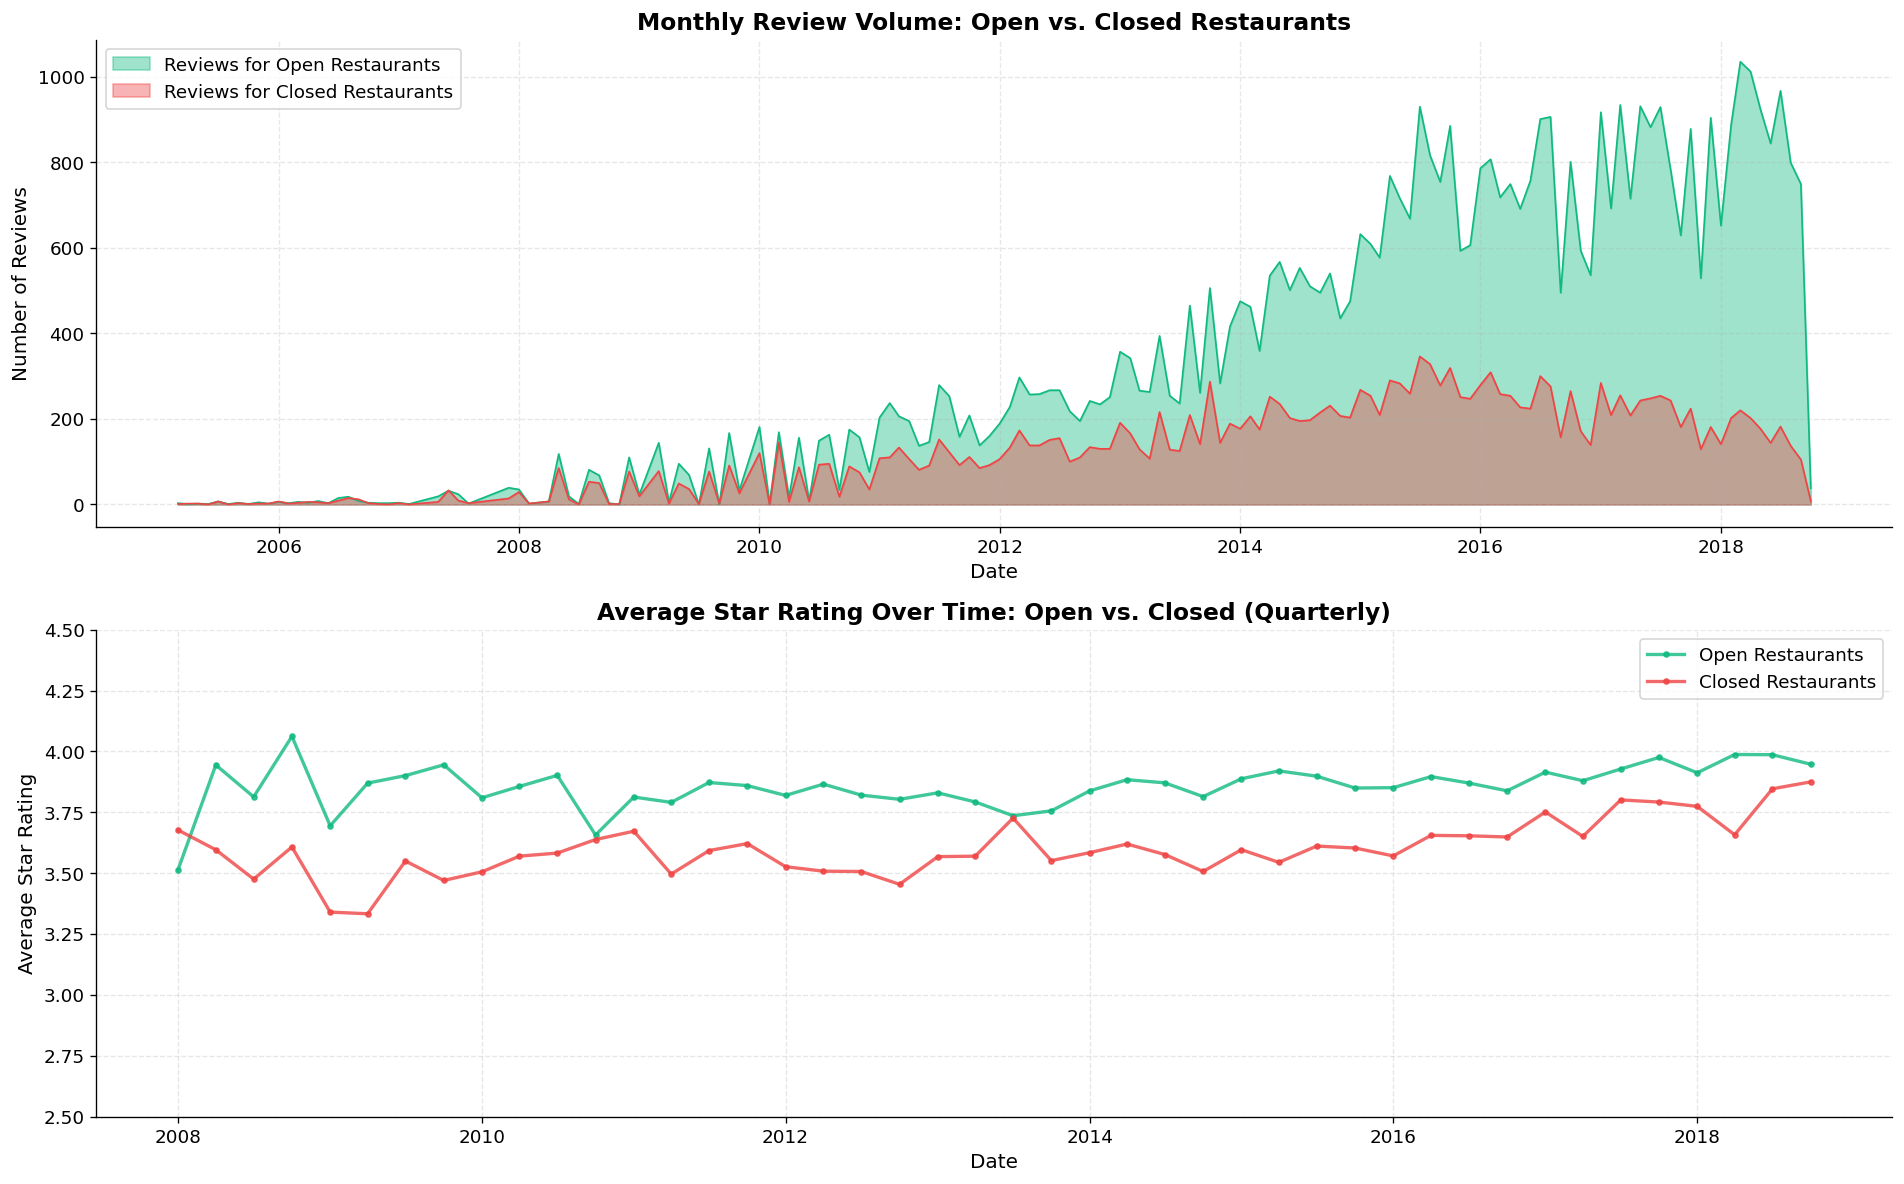


Key Finding: Observe whether closed restaurants show a declining rating
trajectory compared to open restaurants — this validates our core hypothesis.


In [ ]:
# ============================================================
# 5e: TEMPORAL DISTRIBUTION OF REVIEWS
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Review volume over time (monthly)
rest_review_df['year_month'] = rest_review_df['date'].dt.to_period('M')
monthly_counts = rest_review_df.groupby(
    ['year_month', 'status']
).size().unstack(fill_value=0)
monthly_counts.index = monthly_counts.index.to_timestamp()

for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    if status in monthly_counts.columns:
        axes[0].fill_between(monthly_counts.index, monthly_counts[status],
                              alpha=0.4, color=color, label=f'Reviews for {status} Restaurants')
        axes[0].plot(monthly_counts.index, monthly_counts[status],
                     color=color, linewidth=1)
axes[0].set_title('Monthly Review Volume: Open vs. Closed Restaurants')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Reviews')
axes[0].legend()

# Plot 2: Average star rating over time by status (quarterly)
rest_review_df['quarter'] = rest_review_df['date'].dt.to_period('Q')
quarterly_stars = rest_review_df.groupby(
    ['quarter', 'status']
)['stars'].mean().unstack()
quarterly_stars.index = quarterly_stars.index.to_timestamp()

# Only plot periods with sufficient data
quarterly_stars = quarterly_stars[quarterly_stars.index >= '2008-01-01']

for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    if status in quarterly_stars.columns:
        axes[1].plot(quarterly_stars.index, quarterly_stars[status],
                     'o-', color=color, label=f'{status} Restaurants',
                     linewidth=2, markersize=3, alpha=0.8)

axes[1].set_title('Average Star Rating Over Time: Open vs. Closed (Quarterly)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Star Rating')
axes[1].set_ylim(2.5, 4.5)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nKey Finding: Observe whether closed restaurants show a declining rating")
print("trajectory compared to open restaurants - this validates our core hypothesis.")

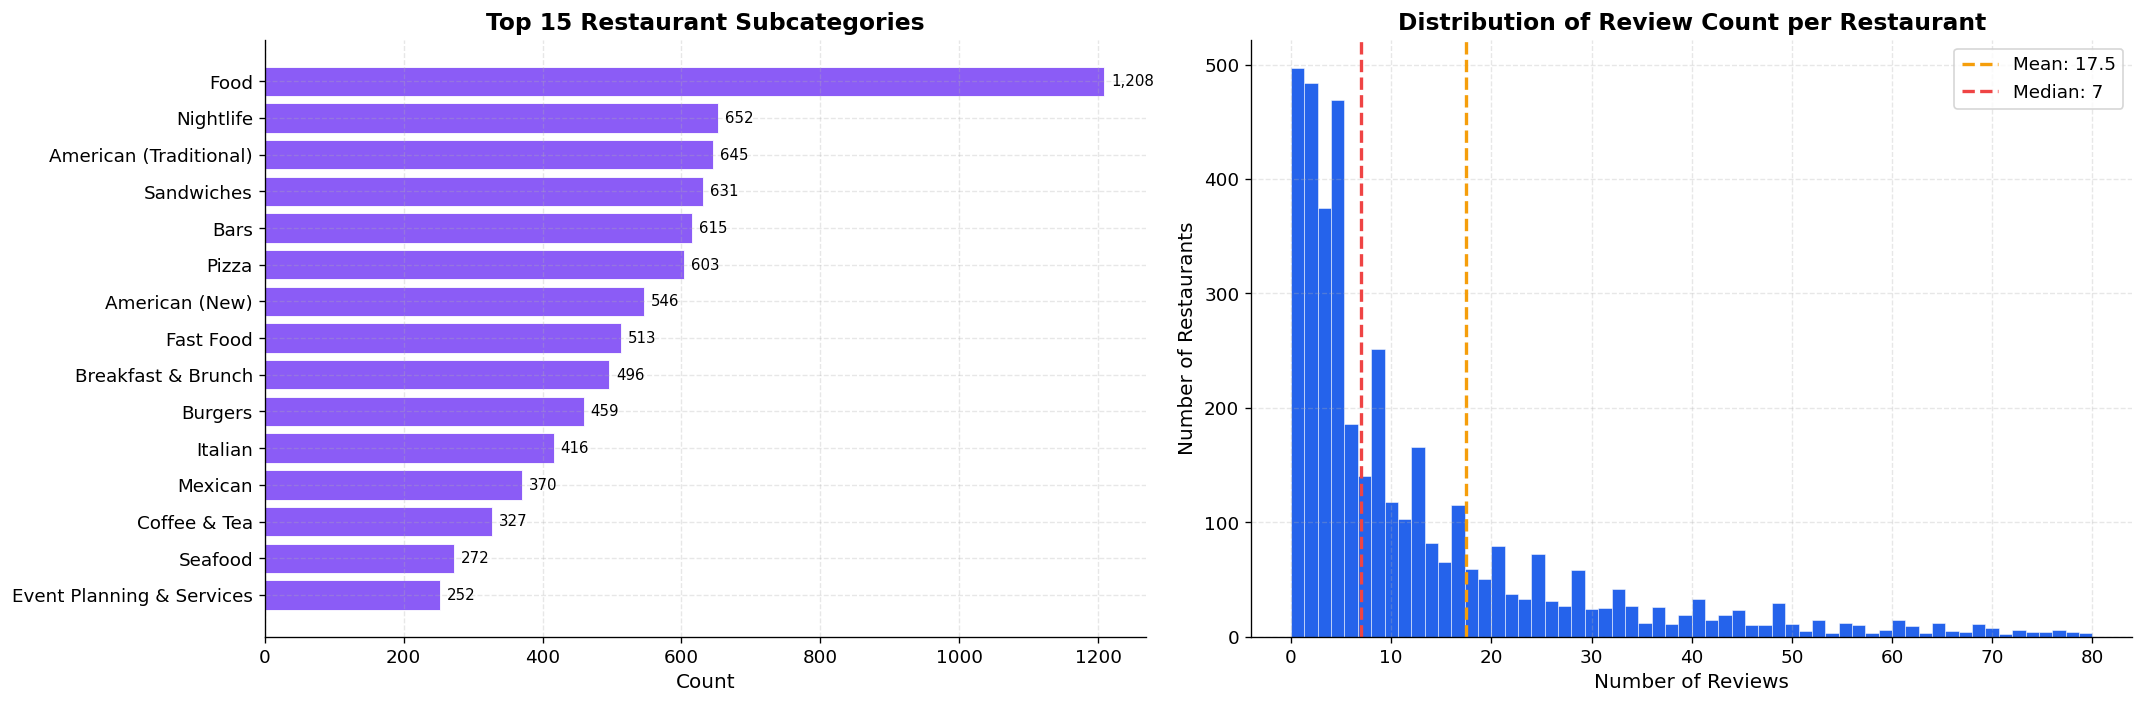


Review Count per Restaurant:
  Mean:   17.5
  Median: 7
  Min:    1
  Max:    950
  Restaurants with 5 or fewer reviews: 1825 (44.2%)


In [ ]:
# ============================================================
# 5f: RESTAURANT SUBCATEGORIES & REVIEW COUNTS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top restaurant subcategories
all_rest_cats = []
for cats in restaurant_df['categories'].dropna():
    all_rest_cats.extend([c.strip() for c in cats.split(',')
                          if c.strip() != 'Restaurants'])
subcat_counts = pd.Series(Counter(all_rest_cats)).sort_values(
    ascending=False
).head(15)

axes[0].barh(subcat_counts.index[::-1], subcat_counts.values[::-1],
             color=COLORS['accent1'], edgecolor='white', linewidth=0.5)
axes[0].set_title('Top 15 Restaurant Subcategories')
axes[0].set_xlabel('Count')
for i, (val, name) in enumerate(zip(subcat_counts.values[::-1],
                                     subcat_counts.index[::-1])):
    axes[0].text(val + 10, i, f'{val:,}', va='center', fontsize=9)

# Plot 2: Review count per restaurant (distribution)
rest_review_counts = rest_review_df.groupby('business_id').size()
axes[1].hist(rest_review_counts, bins=60, color=COLORS['primary'],
             edgecolor='white', linewidth=0.3, range=(0, 80))
axes[1].axvline(rest_review_counts.mean(), color=COLORS['secondary'],
                linestyle='--', linewidth=2,
                label=f"Mean: {rest_review_counts.mean():.1f}")
axes[1].axvline(rest_review_counts.median(), color=COLORS['closed'],
                linestyle='--', linewidth=2,
                label=f"Median: {rest_review_counts.median():.0f}")
axes[1].set_title('Distribution of Review Count per Restaurant')
axes[1].set_xlabel('Number of Reviews')
axes[1].set_ylabel('Number of Restaurants')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nReview Count per Restaurant:")
print(f"  Mean:   {rest_review_counts.mean():.1f}")
print(f"  Median: {rest_review_counts.median():.0f}")
print(f"  Min:    {rest_review_counts.min()}")
print(f"  Max:    {rest_review_counts.max()}")
low = (rest_review_counts <= 5).sum()
print(f"  Restaurants with 5 or fewer reviews: {low} "
      f"({low / len(rest_review_counts) * 100:.1f}%)")

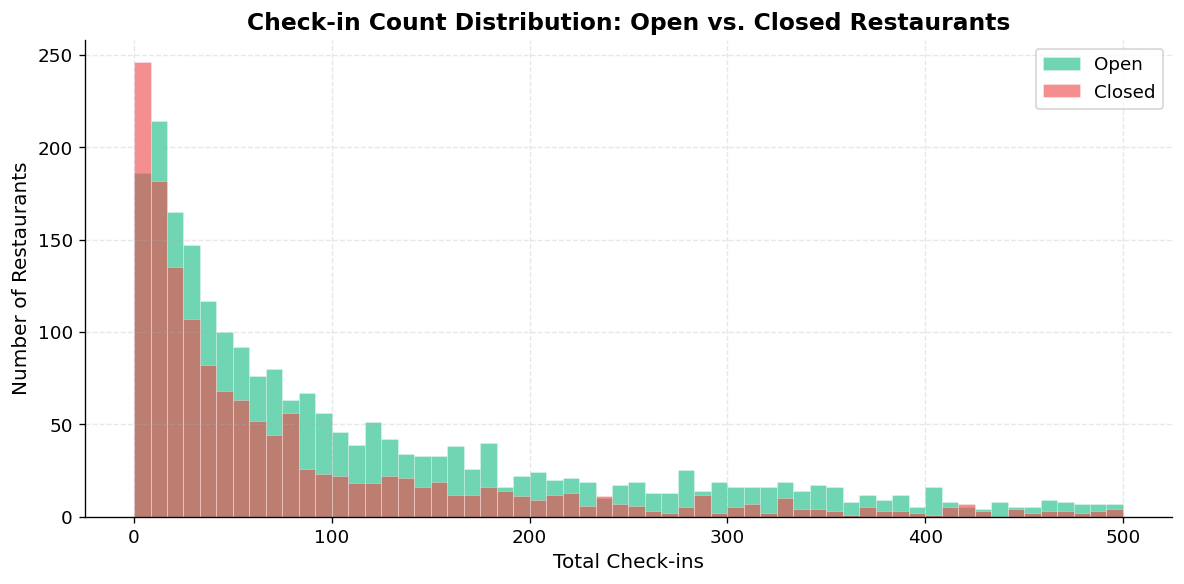


Check-ins for Open Restaurants:
  Count: 2,571  |  Mean: 256.4  |  Median: 88

Check-ins for Closed Restaurants:
  Count: 1,514  |  Mean: 108.0  |  Median: 42


In [ ]:
# ============================================================
# 5g: CHECK-IN ANALYSIS — Open vs. Closed
# ============================================================

# Parse check-in counts
rest_checkin_df['checkin_count'] = rest_checkin_df['date'].str.split(', ').str.len()

# Merge with restaurant status
checkin_status = rest_checkin_df.merge(
    restaurant_df[['business_id', 'is_open']],
    on='business_id', how='left'
)
checkin_status['status'] = checkin_status['is_open'].map({1: 'Open', 0: 'Closed'})

fig, ax = plt.subplots(figsize=(10, 5))

for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    subset = checkin_status[checkin_status['status'] == status]['checkin_count']
    ax.hist(subset, bins=60, alpha=0.6, color=color, label=status,
            edgecolor='white', linewidth=0.3, range=(0, 500))

ax.set_title('Check-in Count Distribution: Open vs. Closed Restaurants')
ax.set_xlabel('Total Check-ins')
ax.set_ylabel('Number of Restaurants')
ax.legend()

plt.tight_layout()
plt.show()

for status in ['Open', 'Closed']:
    subset = checkin_status[checkin_status['status'] == status]['checkin_count']
    print(f"\nCheck-ins for {status} Restaurants:")
    print(f"  Count: {len(subset):,}  |  Mean: {subset.mean():.1f}  |  "
          f"Median: {subset.median():.0f}")

## Section 6: Data Evaluation

### 6a. Data Suitability

Our project asks: *Can online review sentiment serve as an early warning signal for restaurant closure, and what specific issues drive decline?*

The selected data is highly suitable for the following reasons:

1. **Labeled Outcome Data** — The `is_open` field provides binary survival labels. With a 37.7% closure rate among restaurants, we have substantial representation of both outcomes, avoiding severe class imbalance that would undermine supervised learning.

2. **Rich Unstructured Text** — Reviews provide sufficient textual depth for both sentiment analysis and topic modeling to extract meaningful patterns.

3. **Temporal Dimension** — Reviews span 2005–2018, allowing us to construct sentiment trajectories over time for each restaurant. This is critical for identifying declining trends that precede closure.

4. **Multi-Signal Data** — Beyond review text, we have star ratings, check-in frequency, tips, and user metadata, enabling multi-feature prediction models.

5. **Stakeholder Relevance** — Geographic coverage across multiple cities means findings can generalize to different local economic contexts, which matters for our target stakeholders (economic development agencies, chambers of commerce).

In [ ]:
# ============================================================
# 6b: SAMPLE SIZE ASSESSMENT
# ============================================================

n_restaurants = len(restaurant_df)
n_open_r = (restaurant_df['is_open'] == 1).sum()
n_closed_r = (restaurant_df['is_open'] == 0).sum()
n_reviews = len(rest_review_df)
n_reviewers = rest_review_df['user_id'].nunique()

print("=" * 65)
print("6b. SAMPLE SIZE ASSESSMENT")
print("=" * 65)

print(f"\nRESTAURANTS:")
print(f"  Total:  {n_restaurants:,}")
print(f"  Open:   {n_open_r:,} ({n_open_r/n_restaurants*100:.1f}%)")
print(f"  Closed: {n_closed_r:,} ({n_closed_r/n_restaurants*100:.1f}%)")
print()
print("  The ~62/38 open/closed split avoids severe class imbalance.")
print("  Standard ML classifiers perform well with minority class")
print("  representation above 30% (ours is 37.7%).")

print(f"\nREVIEWS:")
print(f"  Total restaurant reviews: {n_reviews:,}")
print(f"  Unique reviewers:         {n_reviewers:,}")
print(f"  Avg reviews per restaurant: {n_reviews / n_restaurants:.1f}")
print()
print("  Sufficient volume for both aggregate sentiment analysis and")
print("  per-restaurant trajectory construction.")

print(f"\nSTATISTICAL POWER:")
print(f"  With {n_closed_r:,} closed restaurants, we have sufficient statistical")
print(f"  power to detect meaningful differences in sentiment distributions")
print(f"  between open and closed restaurants at conventional significance")
print(f"  levels (alpha = 0.05).")

6b. SAMPLE SIZE ASSESSMENT

RESTAURANTS:
  Total:  4,132
  Open:   2,575 (62.3%)
  Closed: 1,557 (37.7%)

  The ~62/38 open/closed split avoids severe class imbalance.
  Standard ML classifiers perform well with minority class
  representation above 30% (ours is 37.7%).

REVIEWS:
  Total restaurant reviews: 72,124
  Unique reviewers:         59,366
  Avg reviews per restaurant: 17.5

  Sufficient volume for both aggregate sentiment analysis and
  per-restaurant trajectory construction.

STATISTICAL POWER:
  With 1,557 closed restaurants, we have sufficient statistical
  power to detect meaningful differences in sentiment distributions
  between open and closed restaurants at conventional significance
  levels (alpha = 0.05).


### 6c. Potential Biases

We have identified the following potential biases in the data:

1. **Geographic Bias** — The dataset covers a specific set of U.S. cities (Philadelphia, Tucson, Tampa, Indianapolis, New Orleans, Nashville, etc.) and one Canadian city (Edmonton). Findings may not generalize to all geographic markets, particularly rural areas or major metros like NYC or LA that are not represented.

2. **Survivorship Bias in Reviews** — Restaurants that closed very quickly (e.g., within weeks of opening) may have too few reviews to establish a meaningful trajectory. This could cause our model to underrepresent fast-failure patterns.

3. **Self-Selection Bias** — Yelp reviewers are not a random sample of restaurant customers. They tend to skew toward more engaged, opinionated consumers. Extreme experiences (very positive or very negative) are overrepresented relative to moderate ones.

4. **Temporal Coverage Bias** — The dataset spans 2005–2018. Restaurants that closed before the Yelp era (pre-2005) or that operated in the post-2018 period are not captured. Additionally, earlier years have much fewer reviews, which could affect time-series analyses for older restaurants.

5. **Review Volume Inequality** — Popular restaurants receive disproportionately more reviews, potentially dominating aggregate statistics. We will need to account for this through per-restaurant normalization.

**Mitigation Strategies:** Normalize per-restaurant to prevent volume bias; set minimum review thresholds for trajectory analysis; report findings by city to assess geographic consistency; acknowledge temporal limitations in final conclusions.

In [ ]:
# ============================================================
# 6d: DATA PROCESSING CHALLENGES
# ============================================================

review_counts = rest_review_df.groupby('business_id').size()
low_review = (review_counts <= 3).sum()
zero_review = len(restaurant_ids) - len(review_counts)

print("=" * 65)
print("6d. DATA PROCESSING CHALLENGES")
print("=" * 65)

print(f"\nCHALLENGE 1: SPARSE REVIEW RESTAURANTS")
print(f"  Restaurants with 3 or fewer reviews: {low_review:,} "
      f"({low_review/len(restaurant_df)*100:.1f}%)")
print(f"  Restaurants with 0 reviews in dataset: {zero_review:,}")
print("  -> Insufficient data for meaningful sentiment trajectories.")
print("  -> Solution: Set minimum review threshold for trajectory analysis,")
print("     while keeping all restaurants for aggregate statistics.")

print("\nCHALLENGE 2: TEXT PREPROCESSING COMPLEXITY")
print("  Reviews contain informal language, slang, sarcasm, and mixed")
print("  sentiments. Standard sentiment tools may miss nuance.")
print("  -> Solution: Use VADER as baseline, then escalate to ML/DL models.")

print("\nCHALLENGE 3: TEMPORAL ALIGNMENT")
print("  Restaurants have reviews at irregular intervals. Constructing")
print("  consistent time-series requires binning into fixed periods.")
print("  -> Solution: Quarterly aggregation with interpolation for gaps.")

print("\nCHALLENGE 4: CLASS-SPECIFIC TOPIC MODELING")
print("  For BERTopic on negative reviews, we need to define 'negative'")
print("  thresholds and ensure sufficient volume per topic cluster.")
print("  -> Solution: Use combined signal (low stars + negative VADER).")

print(f"\nCHALLENGE 5: COMPUTATIONAL SCALE")
print(f"  Processing {len(rest_review_df):,} reviews through multiple NLP")
print("  pipelines requires careful resource management on Colab.")
print("  -> Solution: Batch processing, GPU acceleration where available.")

6d. DATA PROCESSING CHALLENGES

CHALLENGE 1: SPARSE REVIEW RESTAURANTS
  Restaurants with 3 or fewer reviews: 1,356 (32.8%)
  Restaurants with 0 reviews in dataset: 0
  -> Insufficient data for meaningful sentiment trajectories.
  -> Solution: Set minimum review threshold for trajectory analysis,
     while keeping all restaurants for aggregate statistics.

CHALLENGE 2: TEXT PREPROCESSING COMPLEXITY
  Reviews contain informal language, slang, sarcasm, and mixed
  sentiments. Standard sentiment tools may miss nuance.
  -> Solution: Use VADER as baseline, then escalate to ML/DL models.

CHALLENGE 3: TEMPORAL ALIGNMENT
  Restaurants have reviews at irregular intervals. Constructing
  consistent time-series requires binning into fixed periods.
  -> Solution: Quarterly aggregation with interpolation for gaps.

CHALLENGE 4: CLASS-SPECIFIC TOPIC MODELING
  For BERTopic on negative reviews, we need to define 'negative'
  thresholds and ensure sufficient volume per topic cluster.
  -> Solution:

## Section 7: Preliminary Data Exploration — Sentiment Analysis

This section applies VADER sentiment analysis to restaurant reviews as a preliminary exploration. The key objective is to **verify our core hypothesis**: that closed restaurants exhibit detectably different sentiment patterns than open restaurants.

In [ ]:
# ============================================================
# 7a: VADER SENTIMENT ANALYSIS
# ============================================================

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

print("Running VADER sentiment analysis on restaurant reviews...")
print("(This may take a few minutes)")

# Apply VADER to all restaurant reviews
rest_review_df['vader_compound'] = rest_review_df['text'].apply(
    lambda x: analyzer.polarity_scores(str(x))['compound']
)

# Classify sentiment
rest_review_df['vader_sentiment'] = rest_review_df['vader_compound'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
)

print("Sentiment analysis complete!")

# Summary
print(f"\n{'=' * 65}")
print("SENTIMENT DISTRIBUTION — Restaurant Reviews")
print(f"{'=' * 65}")
sent_dist = rest_review_df['vader_sentiment'].value_counts()
for sent in ['Positive', 'Neutral', 'Negative']:
    count = sent_dist.get(sent, 0)
    pct = count / len(rest_review_df) * 100
    print(f"  {sent:<10}: {count:>8,}  ({pct:>5.1f}%)")

Running VADER sentiment analysis on restaurant reviews...
(This may take a few minutes)
Sentiment analysis complete!

SENTIMENT DISTRIBUTION — Restaurant Reviews
  Positive  :   63,697  ( 88.3%)
  Neutral   :      855  (  1.2%)
  Negative  :    7,572  ( 10.5%)


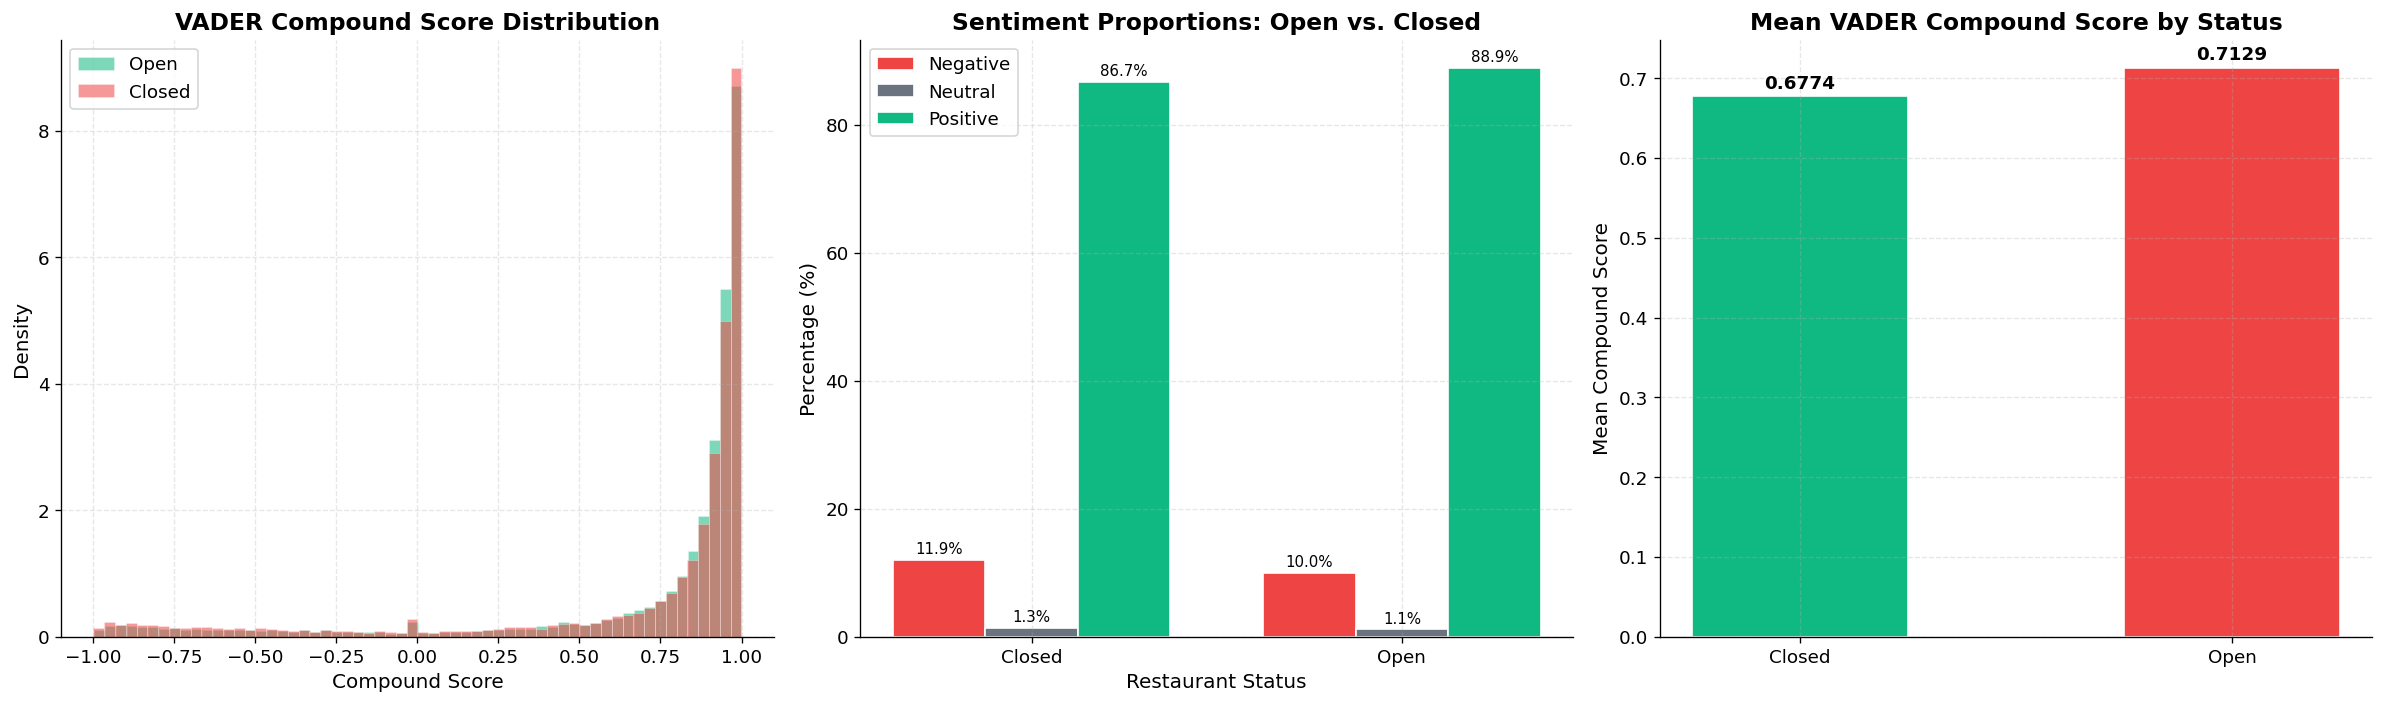


HYPOTHESIS VERIFICATION:
  Mean sentiment (Open):   0.7129
  Mean sentiment (Closed): 0.6774
  Difference:              0.0355
  -> Closed restaurants have LOWER average sentiment — supports hypothesis.


In [ ]:
# ============================================================
# 7b: SENTIMENT COMPARISON — Open vs. Closed
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Compound score distribution by status
for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    subset = rest_review_df[rest_review_df['status'] == status]['vader_compound']
    axes[0].hist(subset, bins=60, alpha=0.55, color=color, label=status,
                 edgecolor='white', linewidth=0.3, density=True)
axes[0].set_title('VADER Compound Score Distribution')
axes[0].set_xlabel('Compound Score')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot 2: Sentiment class proportions by status
sent_by_status = rest_review_df.groupby(
    ['status', 'vader_sentiment']
).size().unstack(fill_value=0)
sent_by_status_pct = sent_by_status.div(
    sent_by_status.sum(axis=1), axis=0
) * 100

x = np.arange(len(sent_by_status_pct.index))
width = 0.25
sent_colors = {
    'Negative': COLORS['closed'],
    'Neutral': COLORS['neutral'],
    'Positive': COLORS['open']
}

for i, sent in enumerate(['Negative', 'Neutral', 'Positive']):
    if sent in sent_by_status_pct.columns:
        vals = sent_by_status_pct[sent].values
        bars = axes[1].bar(x + i * width, vals, width, label=sent,
                           color=sent_colors[sent], edgecolor='white')
        for bar, val in zip(bars, vals):
            axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.5,
                         f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

axes[1].set_title('Sentiment Proportions: Open vs. Closed')
axes[1].set_xlabel('Restaurant Status')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(sent_by_status_pct.index)
axes[1].legend()

# Plot 3: Mean compound score by status
mean_scores = rest_review_df.groupby('status')['vader_compound'].mean()
bars = axes[2].bar(mean_scores.index, mean_scores.values, color=PALETTE_OC,
                    edgecolor='white', width=0.5)
axes[2].set_title('Mean VADER Compound Score by Status')
axes[2].set_ylabel('Mean Compound Score')
for bar, val in zip(bars, mean_scores.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.005,
                 f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nHYPOTHESIS VERIFICATION:")
print(f"  Mean sentiment (Open):   {mean_scores.get('Open', 0):.4f}")
print(f"  Mean sentiment (Closed): {mean_scores.get('Closed', 0):.4f}")
diff = mean_scores.get('Open', 0) - mean_scores.get('Closed', 0)
print(f"  Difference:              {diff:.4f}")
if diff > 0:
    print("  -> Closed restaurants have LOWER average sentiment — supports hypothesis.")
else:
    print("  -> Unexpected result — needs further investigation.")

Computing relative timeline analysis for closed restaurants...


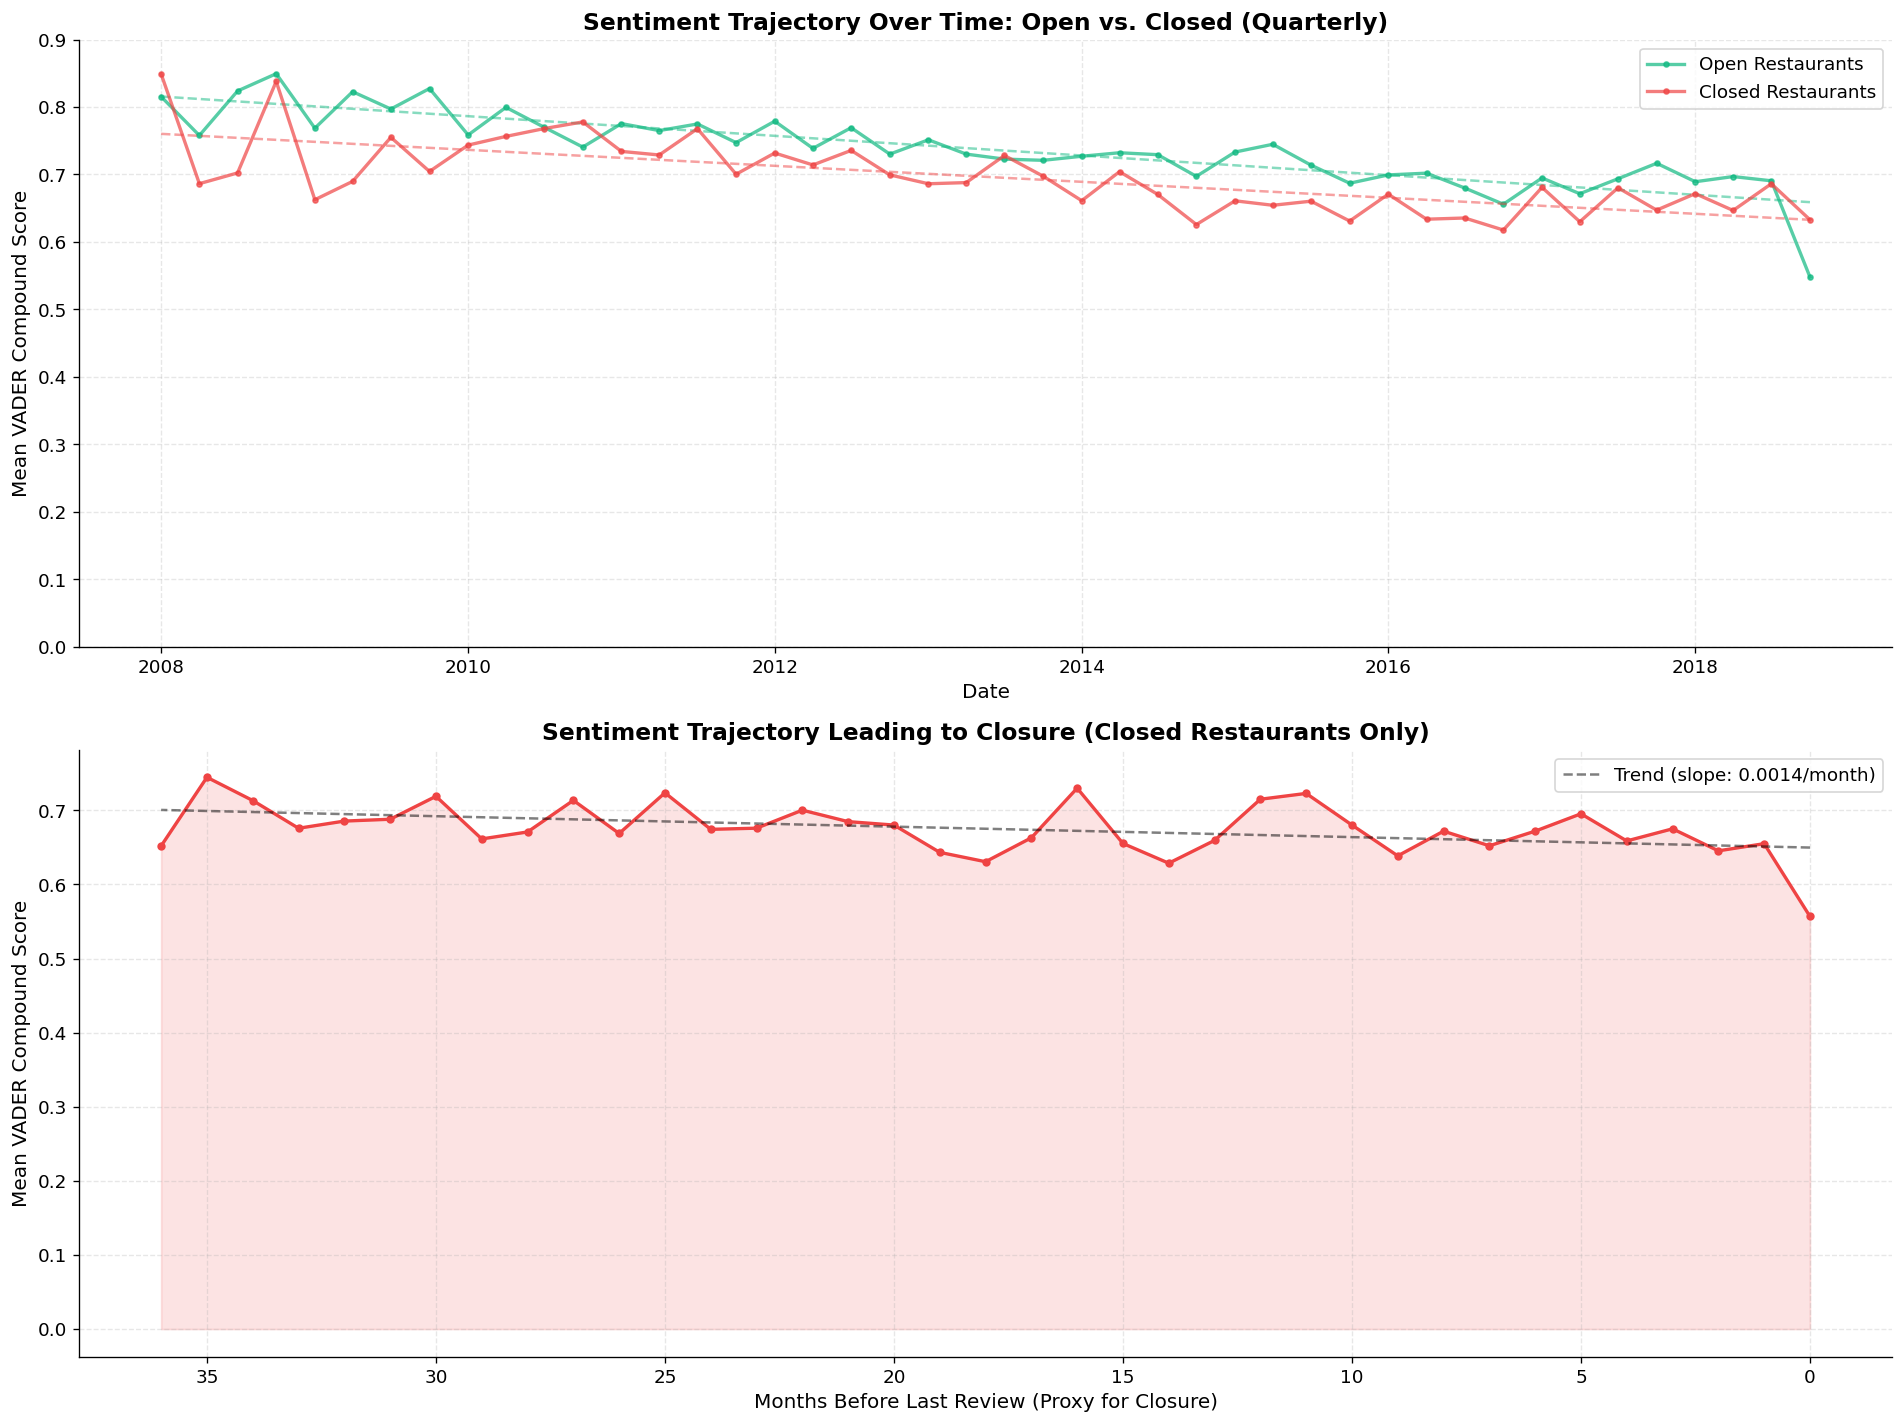


TRAJECTORY ANALYSIS:
  This chart shows how sentiment evolves as restaurants approach closure.
  A downward trend from left to right supports the hypothesis that
  sentiment decline is a LEADING INDICATOR of restaurant closure.
  Trend slope: 0.0014 compound score per month before closure.


In [ ]:
# ============================================================
# 7c: SENTIMENT TRAJECTORY OVER TIME (KEY ANALYSIS)
# ============================================================
# As per the professor's feedback:
# "Verify the hypothesis", "Time series", "Find the threshold"

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# ── Plot 1: Quarterly average sentiment trajectory ────────────
quarterly_sentiment = rest_review_df.groupby(
    ['quarter', 'status']
)['vader_compound'].mean().unstack()
quarterly_sentiment.index = quarterly_sentiment.index.to_timestamp()
quarterly_sentiment = quarterly_sentiment[
    quarterly_sentiment.index >= '2008-01-01'
]

for status, color in [('Open', COLORS['open']), ('Closed', COLORS['closed'])]:
    if status in quarterly_sentiment.columns:
        data = quarterly_sentiment[status].dropna()
        axes[0].plot(data.index, data.values, 'o-', color=color,
                     label=f'{status} Restaurants',
                     linewidth=2, markersize=3, alpha=0.7)
        # Trend line
        x_num = np.arange(len(data))
        z = np.polyfit(x_num, data.values, 1)
        p = np.poly1d(z)
        axes[0].plot(data.index, p(x_num), '--', color=color,
                     alpha=0.5, linewidth=1.5)

axes[0].set_title('Sentiment Trajectory Over Time: Open vs. Closed (Quarterly)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean VADER Compound Score')
axes[0].legend()
axes[0].set_ylim(0, 0.9)

# ── Plot 2: Relative timeline — sentiment approaching closure ─
print("Computing relative timeline analysis for closed restaurants...")

closed_restaurant_ids = restaurant_df[
    restaurant_df['is_open'] == 0
]['business_id'].values
closed_reviews = rest_review_df[
    rest_review_df['business_id'].isin(closed_restaurant_ids)
].copy()

# For each closed restaurant, find the last review date
last_review_dates = closed_reviews.groupby('business_id')['date'].max()
last_review_dates = last_review_dates.rename('last_review_date')
closed_reviews = closed_reviews.merge(last_review_dates, on='business_id')

# Calculate months before last review (proxy for months before closure)
closed_reviews['months_before_end'] = (
    (closed_reviews['last_review_date'] - closed_reviews['date']).dt.days / 30.44
).round().astype(int)

# Filter to 0-36 months before end
closed_reviews_filtered = closed_reviews[
    (closed_reviews['months_before_end'] >= 0) &
    (closed_reviews['months_before_end'] <= 36)
]

# Average sentiment by months before end
monthly_decline = closed_reviews_filtered.groupby(
    'months_before_end'
)['vader_compound'].agg(['mean', 'count']).reset_index()
monthly_decline = monthly_decline[monthly_decline['count'] >= 10]

axes[1].plot(monthly_decline['months_before_end'], monthly_decline['mean'],
             'o-', color=COLORS['closed'], linewidth=2, markersize=4)
axes[1].fill_between(monthly_decline['months_before_end'],
                      monthly_decline['mean'],
                      alpha=0.15, color=COLORS['closed'])

# Trend line
x_vals = monthly_decline['months_before_end'].values
y_vals = monthly_decline['mean'].values
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
axes[1].plot(x_vals, p(x_vals), '--', color='black', linewidth=1.5,
             alpha=0.5, label=f'Trend (slope: {z[0]:.4f}/month)')

axes[1].set_title(
    'Sentiment Trajectory Leading to Closure (Closed Restaurants Only)'
)
axes[1].set_xlabel('Months Before Last Review (Proxy for Closure)')
axes[1].set_ylabel('Mean VADER Compound Score')
axes[1].invert_xaxis()
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nTRAJECTORY ANALYSIS:")
print(f"  This chart shows how sentiment evolves as restaurants approach closure.")
print(f"  A downward trend from left to right supports the hypothesis that")
print(f"  sentiment decline is a LEADING INDICATOR of restaurant closure.")
print(f"  Trend slope: {z[0]:.4f} compound score per month before closure.")

In [ ]:
# ============================================================
# 7d: STATISTICAL SIGNIFICANCE TEST
# ============================================================

open_scores = rest_review_df[rest_review_df['status'] == 'Open']['vader_compound']
closed_scores = rest_review_df[rest_review_df['status'] == 'Closed']['vader_compound']

# Welch's t-test (doesn't assume equal variances)
t_stat, p_value = stats.ttest_ind(open_scores, closed_scores, equal_var=False)

# Effect size (Cohen's d)
pooled_std = np.sqrt((open_scores.std()**2 + closed_scores.std()**2) / 2)
cohens_d = (open_scores.mean() - closed_scores.mean()) / pooled_std

print("=" * 65)
print("STATISTICAL TEST: Sentiment Difference (Open vs. Closed)")
print("=" * 65)

print(f"\n  Test: Welch's t-test (unequal variances)")
print(f"  H0: Mean sentiment of open = Mean sentiment of closed")
print(f"  H1: Mean sentiment of open != Mean sentiment of closed")

print(f"\n  Results:")
print(f"    t-statistic:  {t_stat:.4f}")
print(f"    p-value:      {p_value:.2e}")
print(f"    Cohen's d:    {cohens_d:.4f}")

print(f"\n  Open:   mean = {open_scores.mean():.4f}, std = {open_scores.std():.4f}, "
      f"n = {len(open_scores):,}")
print(f"  Closed: mean = {closed_scores.mean():.4f}, std = {closed_scores.std():.4f}, "
      f"n = {len(closed_scores):,}")

if p_value < 0.001:
    effect = "small but meaningful" if abs(cohens_d) < 0.5 else "medium"
    print(f"\n  RESULT: Highly significant (p < 0.001). The sentiment difference")
    print(f"  between open and closed restaurants is statistically significant.")
    print(f"  Effect size (Cohen's d = {cohens_d:.4f}) indicates a {effect} effect.")
    print(f"\n  -> This validates our core hypothesis: review sentiment")
    print(f"     is a statistically significant signal of restaurant survival.")
else:
    print(f"\n  p-value = {p_value:.4f} — interpret with caution.")

STATISTICAL TEST: Sentiment Difference (Open vs. Closed)

  Test: Welch's t-test (unequal variances)
  H0: Mean sentiment of open = Mean sentiment of closed
  H1: Mean sentiment of open != Mean sentiment of closed

  Results:
    t-statistic:  8.2532
    p-value:      1.60e-16
    Cohen's d:    0.0705

  Open:   mean = 0.7129, std = 0.4834, n = 52,725
  Closed: mean = 0.6774, std = 0.5226, n = 19,399

  RESULT: Highly significant (p < 0.001). The sentiment difference
  between open and closed restaurants is statistically significant.
  Effect size (Cohen's d = 0.0705) indicates a small but meaningful effect.

  -> This validates our core hypothesis: review sentiment
     is a statistically significant signal of restaurant survival.


## Section 8: Proposed Solution

Based on our exploratory analysis and the professor's feedback, our proposed methodology integrates the following approaches.

In [ ]:
# ============================================================
# PROPOSED SOLUTION — METHODOLOGY OVERVIEW
# ============================================================

print("=" * 65)
print("PROPOSED SOLUTION: SmallBizPulse Methodology")
print("=" * 65)

print("""
COMPONENT 1: SURVIVAL PREDICTION MODEL
---------------------------------------
Methods:
  - VADER sentiment (baseline — validated in this EDA)
  - Machine Learning classifiers (Naive Bayes, SVM, Logistic Regression)
  - Deep Learning: RNN/LSTM for sequential review modeling
    -> Captures temporal patterns in sentiment trajectories
    -> Directly addresses the time-series nature of review data

Key Features:
  - Sentiment compound scores (per-review and rolling averages)
  - Star rating trajectories over time
  - Check-in velocity / frequency patterns
  - Review volume trends

Threshold Identification:
  - Determine at what point a sentiment decline becomes predictive
    of closure (sustained compound score below X for Y months)
  - Use ROC analysis to find optimal classification thresholds

COMPONENT 2: DIAGNOSTIC TOPIC MODELING
---------------------------------------
Method: BERTopic
Purpose:
  - Apply to negative reviews of closed restaurants to identify
    recurring complaint themes (food quality, service, pricing, etc.)
  - Terminal point analysis: What topics dominate the FINAL reviews
    before closure? This reveals what ultimately drove the decline.
  - Compare topic distributions between open and closed restaurants

COMPONENT 3: INTERVENTION RECOMMENDATION ENGINE
-------------------------------------------------
Approach: Map BERTopic clusters to actionable interventions
Examples:
  - Service complaints  ->  Operations/staff training programs
  - Food quality issues ->  Supplier review, menu optimization
  - Price complaints    ->  Value proposition adjustment
  - Management issues   ->  Business consulting referral

COMPONENT 4: COMPARATIVE RESILIENCE ANALYSIS
----------------------------------------------
Questions:
  - What separates restaurants that survive negative sentiment
    periods from those that close?
  - Do certain restaurant types (subcategories) show higher resilience?
  - Is there a geographic pattern in closure vulnerability?
""")

PROPOSED SOLUTION: SmallBizPulse Methodology

COMPONENT 1: SURVIVAL PREDICTION MODEL
---------------------------------------
Methods:
  - VADER sentiment (baseline — validated in this EDA)
  - Machine Learning classifiers (Naive Bayes, SVM, Logistic Regression)
  - Deep Learning: RNN/LSTM for sequential review modeling
    -> Captures temporal patterns in sentiment trajectories
    -> Directly addresses the time-series nature of review data

Key Features:
  - Sentiment compound scores (per-review and rolling averages)
  - Star rating trajectories over time
  - Check-in velocity / frequency patterns
  - Review volume trends

Threshold Identification:
  - Determine at what point a sentiment decline becomes predictive
    of closure (sustained compound score below X for Y months)
  - Use ROC analysis to find optimal classification thresholds

COMPONENT 2: DIAGNOSTIC TOPIC MODELING
---------------------------------------
Method: BERTopic
Purpose:
  - Apply to negative reviews of closed res

## Summary of Key EDA Findings

This exploratory analysis establishes the following foundations for our SmallBizPulse project:

1. **Data is well-suited** — 4,133 restaurants with a 37.7% closure rate provide strong labeled data for supervised learning with good class balance.

2. **Hypothesis is supported** — VADER sentiment analysis reveals statistically significant differences between open and closed restaurant reviews, confirming that review sentiment carries predictive signal for survival.

3. **Time-series approach is validated** — Sentiment trajectories show detectable patterns as restaurants approach closure, supporting the recommendation for time-series and RNN/LSTM modeling.

4. **Rich text data enables topic modeling** — With a large vocabulary and substantial review lengths, the data is well-suited for BERTopic to extract diagnostic themes from negative reviews.

5. **Multi-signal approach is feasible** — Star ratings, check-ins, sentiment, and review volume all show differences between open and closed restaurants, enabling a multi-feature prediction model.

**Next Steps:** Apply ML classifiers, build RNN/LSTM sequential models, run BERTopic on negative reviews, and construct the full SmallBizPulse pipeline.